## AMD GPU Setup

In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '11.0.0'

gfx_version = os.getenv('HSA_OVERRIDE_GFX_VERSION')
print(f"HSA_OVERRIDE_GFX_VERSION is set to: {gfx_version}")

HSA_OVERRIDE_GFX_VERSION is set to: 11.0.0


In [2]:
#test
import torch

t = torch.tensor([5, 5, 5], dtype=torch.int64, device='cuda')
t_f32 = torch.tensor([5, 5, 5], dtype=torch.float32, device='cuda')
print('Testing PyTorch ROCM support...')
if str(t) == "tensor([5, 5, 5], device='cuda:0')" and str(t_f32) == "tensor([5., 5., 5.], device='cuda:0')":
    print(True)

Testing PyTorch ROCM support...
True


In [11]:
import warnings
warnings.filterwarnings("ignore")

-------------------------------------

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("combined_dataset.csv")

In [6]:
df.head()

,domain,text
0,orthopedic_surgery,Persistent hip pain suggests possible tendinop...
1,plastic_surgery,Suture removal completed; no complications.
2,ophthalmology,Severe photophobia with tearing.
3,dermatology,Psoriasis flare noted after recent stress.
4,orthopedic_surgery,Bone fusion expected within next six weeks.


In [7]:
sentences = df["text"].tolist()

In [8]:
len(sentences), type(sentences)

(757, list)

In [14]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

2025-12-14 01:01:07.415769: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-14 01:01:07.770375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/init/.local/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/init/

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [17]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
all_embeddings = []

for sentence in sentences:
    # Use device for tokenizer inputs
    inputs = tokenizer(
        sentence, 
        return_tensors="pt", 
        padding=True, 
        truncation=True,
        max_length=512 # Ensure consistent max length
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    token_embeddings = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']

    # Correctly compute mean-pooling while taking the attention mask into account
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) # Compute Weighted Sum of Token Embeddings
    
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) # Compute Number of Real Tokens
    embedding = sum_embeddings / sum_mask

    # L2 Normalize the embeddings (Standard practice for cosine similarity)
    embedding = torch.nn.functional.normalize(embedding, p=2, dim=1) 
    
    all_embeddings.append(embedding.cpu().numpy())


In [19]:
len(all_embeddings), all_embeddings[0].shape

(757, (1, 768))

In [20]:
all_embeddings[0]

array([[ 4.42436114e-02, -5.50071150e-03, -3.71369114e-03,
         2.35175458e-03,  7.38759991e-03,  1.42925708e-02,
         1.67214926e-02, -7.34013692e-03,  2.55258824e-03,
         1.81095675e-03,  9.23524052e-03,  1.32737868e-02,
        -2.73219272e-02, -5.21073164e-03, -8.70872289e-03,
         1.51459026e-04,  1.20061776e-02,  1.13381352e-02,
         3.64214857e-03,  1.27998702e-02, -4.06771488e-02,
        -1.61629375e-02, -3.43951248e-02, -1.46438461e-02,
        -2.70621898e-03, -2.10382901e-02,  4.04643069e-04,
         3.95751745e-02, -2.40396578e-02,  1.80906449e-02,
         2.65016686e-03,  7.46167148e-04,  1.90224182e-02,
         6.24647969e-03,  1.22711004e-03,  3.24803926e-02,
         1.77366231e-02,  5.84295904e-03,  9.84977372e-03,
         4.97951778e-03, -9.14945453e-03,  8.58204346e-03,
         2.87405145e-03,  1.05022145e-02,  3.91864106e-02,
        -3.18464674e-02,  2.99101714e-02, -7.10149622e-03,
        -4.21507247e-02,  3.87894572e-03,  2.13237479e-0

In [21]:
import numpy as np
emb_array = np.array(all_embeddings)      # shape (757, 1, 768)
emb_array.shape

(757, 1, 768)

In [22]:
emb_2d = np.squeeze(emb_array, axis=1)    # shape becomes (757, 768)
emb_2d.shape

(757, 768)

In [23]:
emb_2d[0]

array([ 4.42436114e-02, -5.50071150e-03, -3.71369114e-03,  2.35175458e-03,
        7.38759991e-03,  1.42925708e-02,  1.67214926e-02, -7.34013692e-03,
        2.55258824e-03,  1.81095675e-03,  9.23524052e-03,  1.32737868e-02,
       -2.73219272e-02, -5.21073164e-03, -8.70872289e-03,  1.51459026e-04,
        1.20061776e-02,  1.13381352e-02,  3.64214857e-03,  1.27998702e-02,
       -4.06771488e-02, -1.61629375e-02, -3.43951248e-02, -1.46438461e-02,
       -2.70621898e-03, -2.10382901e-02,  4.04643069e-04,  3.95751745e-02,
       -2.40396578e-02,  1.80906449e-02,  2.65016686e-03,  7.46167148e-04,
        1.90224182e-02,  6.24647969e-03,  1.22711004e-03,  3.24803926e-02,
        1.77366231e-02,  5.84295904e-03,  9.84977372e-03,  4.97951778e-03,
       -9.14945453e-03,  8.58204346e-03,  2.87405145e-03,  1.05022145e-02,
        3.91864106e-02, -3.18464674e-02,  2.99101714e-02, -7.10149622e-03,
       -4.21507247e-02,  3.87894572e-03,  2.13237479e-02,  3.02033722e-02,
        2.91728368e-03, -

In [24]:
train, test = emb_2d[:650], emb_2d[651:757]


In [25]:
from sklearn.cluster import KMeans

In [26]:
no_of_clusters = 5
means = KMeans(n_clusters=no_of_clusters)

In [27]:
means.fit(train)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [28]:
y_test = means.fit_predict(test)

In [29]:
y_train = means.fit_predict(train)

In [30]:
y_train

array([1, 2, 4, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 1, 2, 4, 0, 2, 1,
       1, 4, 1, 1, 1, 1, 0, 4, 0, 2, 4, 2, 1, 1, 2, 3, 3, 3, 0, 2, 4, 4,
       3, 2, 3, 4, 3, 3, 1, 0, 2, 1, 1, 0, 1, 1, 3, 2, 1, 1, 2, 1, 2, 3,
       1, 1, 3, 0, 2, 0, 3, 4, 2, 1, 2, 1, 4, 2, 3, 3, 4, 2, 2, 2, 3, 1,
       3, 2, 1, 2, 1, 4, 1, 0, 2, 2, 2, 3, 1, 1, 2, 4, 1, 2, 0, 0, 0, 0,
       1, 2, 3, 3, 2, 0, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 2, 1, 3, 0,
       1, 1, 0, 2, 4, 1, 0, 1, 1, 2, 0, 2, 3, 3, 2, 4, 0, 2, 2, 1, 1, 2,
       3, 2, 4, 0, 2, 4, 3, 1, 2, 0, 1, 1, 2, 0, 2, 0, 4, 0, 3, 2, 3, 3,
       1, 3, 2, 2, 2, 3, 3, 1, 3, 1, 3, 1, 0, 4, 2, 3, 4, 2, 0, 1, 3, 0,
       1, 2, 0, 1, 3, 1, 1, 0, 0, 3, 0, 2, 4, 3, 2, 3, 2, 0, 0, 0, 1, 1,
       3, 3, 2, 4, 4, 1, 2, 1, 4, 0, 3, 0, 4, 0, 3, 3, 1, 0, 4, 2, 4, 0,
       4, 0, 3, 2, 3, 4, 3, 4, 4, 3, 3, 4, 1, 3, 1, 1, 2, 1, 1, 1, 0, 2,
       2, 0, 3, 2, 0, 2, 0, 2, 4, 3, 0, 3, 4, 0, 0, 1, 1, 0, 4, 0, 3, 1,
       2, 4, 2, 1, 1, 2, 2, 2, 1, 3, 1, 4, 2, 4, 4,

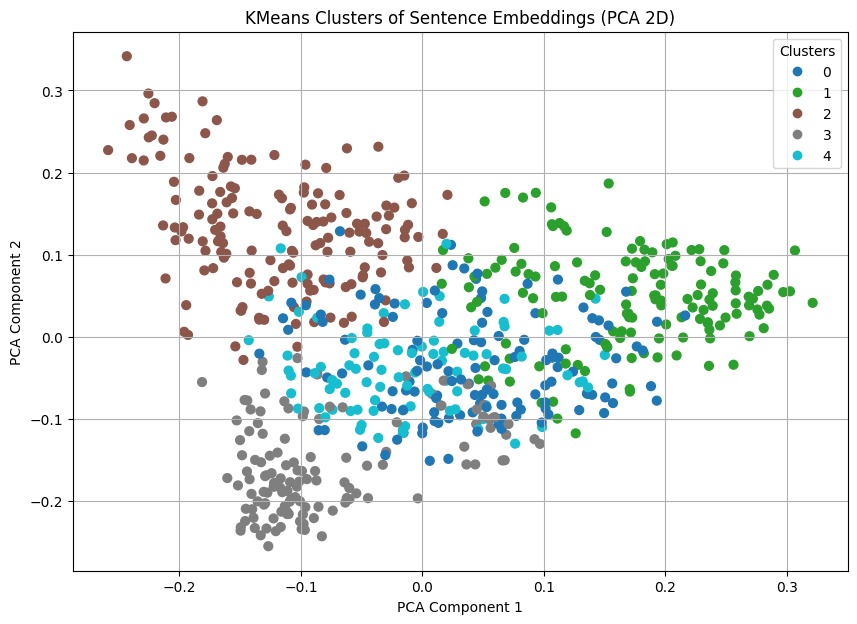

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Reduce 512D → 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(train)

# Step 2: Scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    emb_2d[:, 0], 
    emb_2d[:, 1], 
    c=y_train, 
    cmap='tab10',
    s=40
)

# Step 3: Add legend
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("KMeans Clusters of Sentence Embeddings (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
